In [ ]:
import zipfile
import os

zip_file_path = "/content/EuroSAT.zip"  # Replace with your file name
destination_dir = "/content/EuroSAT"

# Unzipping the file
os.makedirs(destination_dir, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

print("Dataset unzipped to:", destination_dir)


Dataset unzipped to: /content/EuroSAT


In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
destination_dir = "/content/EuroSAT"

os.chdir(destination_dir)
print("Current Working Directory:", os.getcwd())


Current Working Directory: /content/EuroSAT


In [ ]:
import os
import pandas as pd

def load_and_prepare_csv(csv_file, base_dir):
    """
    Load a CSV file and prepare image paths and labels.

    Args:
        csv_file (str): Path to the CSV file.
        base_dir (str): Base directory containing the images.

    Returns:
        tuple: (list of full image paths, list of class names)
    """
    # Load the CSV file
    data = pd.read_csv(csv_file)

    # Rename columns to desired names
    data.rename(
        columns={
            data.columns[0]: "id",         # First column becomes "id"
            data.columns[1]: "path",      # Second column becomes "path"
            data.columns[2]: "class_id",  # Third column becomes "class_id"
            data.columns[3]: "class_name" # Fourth column becomes "class_name"
        },
        inplace=True
    )

    # Prepend the base directory to the "path" column
    def construct_full_path(file_path):
        full_path = os.path.join(base_dir, file_path)
        if not os.path.exists(full_path):
            print(f"Warning: File {file_path} not found at {full_path}")
        return full_path

    # Construct full paths for all images
    data["path"] = data["path"].apply(lambda x: construct_full_path(x))

    # Return the image paths and class labels as separate outputs
    return data["path"].tolist(), data["class_name"].tolist()

# Define paths for Colab
base_folder = "/content/EuroSAT/EuroSAT"  # Adjusted base directory for Colab
train_csv = os.path.join(base_folder, "train.csv")
test_csv = os.path.join(base_folder, "test.csv")
validation_csv = os.path.join(base_folder, "validation.csv")

# Preprocess datasets
X_train_paths, y_train_labels = load_and_prepare_csv(train_csv, base_folder)
X_test_paths, y_test_labels = load_and_prepare_csv(test_csv, base_folder)
X_val_paths, y_val_labels = load_and_prepare_csv(validation_csv, base_folder)

# Print dataset sizes
print(f"Training Set: {len(X_train_paths)} images, {len(y_train_labels)} labels")
print(f"Test Set: {len(X_test_paths)} images, {len(y_test_labels)} labels")
print(f"Validation Set: {len(X_val_paths)} images, {len(y_val_labels)} labels")


Training Set: 18900 images, 18900 labels
Test Set: 2700 images, 2700 labels
Validation Set: 5400 images, 5400 labels


In [ ]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, VGG16

# Load VGG16 model without the top layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Preprocessing function for images
def preprocess_images(image_paths, target_size=(128, 128)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)  # Load image
        img_array = img_to_array(img)  # Convert to array
        img_array = preprocess_input(img_array)  # Preprocess for VGG16
        images.append(img_array)
    return np.array(images)

# Feature extraction function
def extract_features(image_paths, model, batch_size=32):
    features = []
    num_samples = len(image_paths)
    num_batches = (num_samples + batch_size - 1) // batch_size

    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, num_samples)
        batch_images = preprocess_images(image_paths[start:end])  # Load and preprocess batch
        batch_features = model.predict(batch_images, batch_size=batch_size)  # Extract features
        batch_features = batch_features.reshape(batch_features.shape[0], -1)  # Flatten
        features.append(batch_features)

    return np.vstack(features)

# Extract features for training, testing, and validation sets
X_train_features = extract_features(X_train_paths, base_model)
X_test_features = extract_features(X_test_paths, base_model)
X_val_features = extract_features(X_val_paths, base_model)

print(f"Train Features: {X_train_features.shape}, Test Features: {X_test_features.shape}, Validation Features: {X_val_features.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

Test Accuracy: 87.74%
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.93      0.88      0.90       300
              Forest       0.93      0.98      0.95       300
HerbaceousVegetation       0.89      0.90      0.89       300
             Highway       0.79      0.73      0.76       250
          Industrial       0.65      0.97      0.78       250
             Pasture       0.91      0.93      0.92       200
       PermanentCrop       0.91      0.76      0.83       250
         Residential       0.97      0.92      0.94       300
               River       0.86      0.71      0.78       250
             SeaLake       0.99      0.96      0.97       300

            accuracy                           0.88      2700
           macro avg       0.88      0.87      0.87      2700
        weighted avg       0.89      0.88      0.88      2700

Overall Test ROC-AUC: 0.98


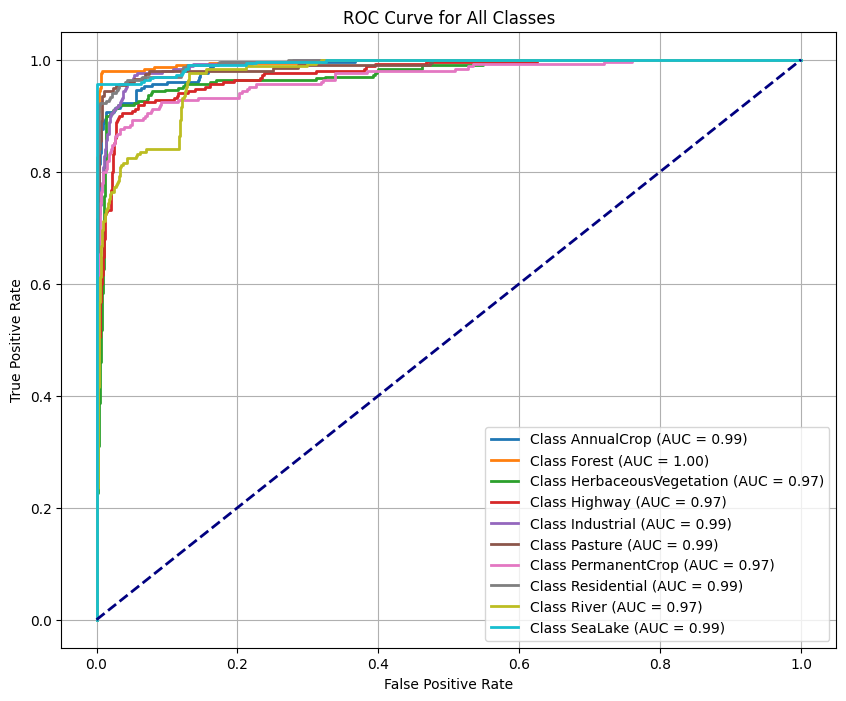

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_labels)
y_test = label_encoder.transform(y_test_labels)
y_val = label_encoder.transform(y_val_labels)

svm_classifier = SVC(kernel='rbf', C=0.1, gamma='scale', random_state=42)
svm_classifier.fit(X_train_features, y_train)

# Test Accuracy
y_test_pred = svm_classifier.predict(X_test_features)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Encode labels for ROC-AUC
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)  # Binarize true labels
y_test_scores = svm_classifier.decision_function(X_test_features)  # Decision scores for ROC

# Compute ROC-AUC for all classes
test_roc_auc = roc_auc_score(y_test_binarized, y_test_scores, multi_class="ovr")
print(f"Overall Test ROC-AUC: {test_roc_auc:.2f}")

# ROC Curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_test_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {class_name} (AUC = {roc_auc:.2f})")

# Plotting ROC Curve
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for All Classes")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
import numpy as np

# Save the features
np.save("X_train_features.npy", X_train_features)
np.save("X_test_features.npy", X_test_features)
np.save("X_val_features.npy", X_val_features)

# Save the labels
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)
np.save("y_val.npy", y_val)

print("Features and labels saved successfully.")

Features and labels saved successfully.


In [ ]:
import joblib

# Save the trained model
model_save_path = "svm_classifier_model.joblib"
joblib.dump(svm_classifier, model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to svm_classifier_model.joblib


In [ ]:
# Load the model
loaded_model = joblib.load("svm_classifier_model.joblib")
print("Model loaded successfully.")

# Load the features and labels
X_train_features = np.load("X_train_features.npy")
X_test_features = np.load("X_test_features.npy")
X_val_features = np.load("X_val_features.npy")

y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")
y_val = np.load("y_val.npy")

print("Features and labels loaded successfully.")


Model loaded successfully.
Features and labels loaded successfully.


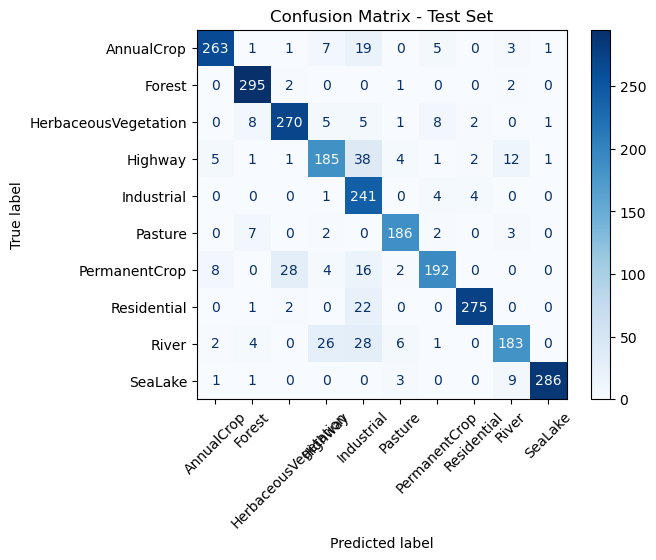

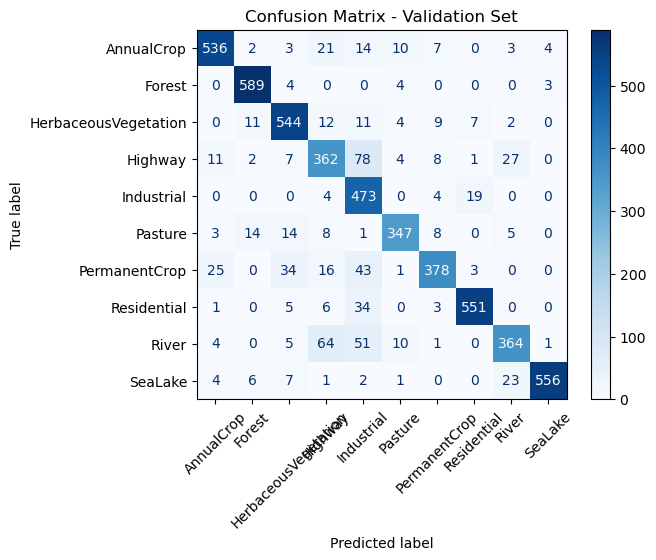

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix for Test Set
y_test_pred = svm_classifier.predict(X_test_features)
test_cm = confusion_matrix(y_test, y_test_pred)

# Display Confusion Matrix for Test Set
test_cm_display = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=label_encoder.classes_)
test_cm_display.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.show()

# Confusion Matrix for Validation Set
y_val_pred = svm_classifier.predict(X_val_features)
val_cm = confusion_matrix(y_val, y_val_pred)

# Display Confusion Matrix for Validation Set
val_cm_display = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=label_encoder.classes_)
val_cm_display.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title("Confusion Matrix - Validation Set")
plt.show()